In [2]:
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
from scipy import signal
import numpy as np
import scipy
from scipy import signal
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter
import cPickle as pkl
import pylab as plt
%matplotlib inline

In [13]:
inds = pkl.load(open('pkls/gaus_trans.pkl','rb'))
data = parallel_rw_pkl(None, 'test_patch', 'r')
mask = parallel_rw_pkl(None, 'mtest_patch', 'r')
modis_sent = ma.array(data, mask=mask)

b4 = parallel_rw_pkl(None, 'b4test_patch', 'r')
stm = parallel_rw_pkl(None, 'stmtest_patch', 'r')
p_mask = np.unique(stm)

Sent = b4
struct = ndimage.generate_binary_structure(2, 2)

<matplotlib.colorbar.Colorbar instance at 0x10771a320>

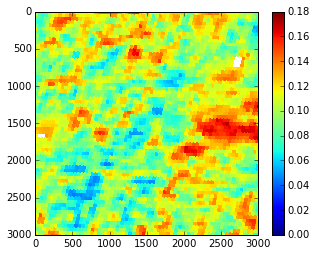

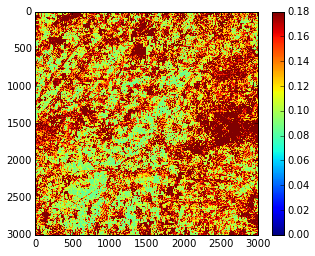

In [34]:
plt.figure(figsize=(5,4))
plt.imshow(modis_sent*0.001,vmin = 0, vmax = 0.18)
plt.colorbar()
plt.figure(figsize=(5,4))
plt.imshow(b4, vmin = 0, vmax = 0.18)
plt.colorbar()

In [1]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2.: center[0]+xwin/2., center[1]-ywin/2.:center[1]+ywin/2.]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

In [274]:
gaus = gaussian(100, 100, 10, 30, 10, norm = True)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [275]:
inds[1].max(), inds[0].max()# center: 49, 112

(98, 224)

In [293]:
def get_pixels(i):
    sent =  np.zeros_like(Sent)
    mask = (stm==i)  
    brdf = (Counter(modis_sent[mask]).most_common(1)[0][0])*0.001
    xmin = np.where(mask)[0].min()
    xmax = np.where(mask)[0].max()
    ymin = np.where(mask)[1].min()
    ymax = np.where(mask)[1].max()
    
    indx = np.where(mask)[0]
    indy = np.where(mask)[1]
    
    center0 = np.array([(xmax+xmin)/2, (ymax+ymin)/2])
    center1 = np.array([49, 112])
    offset = center0 - center1
    if any(offset<0):
        print 'Offset < 0, center of mask and patch: %s %s'%(center0,center1)
        pass
    else:
        x = inds[1] + offset[0]
        y = inds[0] + offset[1]
    
    convm = np.zeros_like(sent).astype('bool')
    convm[x, y] = True
    
    dia_mask = bd(convm, structure=struct, iterations=100)
    sent[dia_mask] = Sent[dia_mask]
    to_conv = sent[min(np.where(dia_mask)[0]):max(np.where(dia_mask)[0])+1,
                   min(np.where(dia_mask)[1]):max(np.where(dia_mask)[1])+1]
    
    return np.array([mask,np.array(to_conv), np.array(brdf), indx, indy], dtype = object)

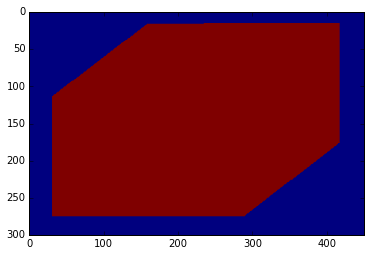

In [252]:
dia_mask = bd(convm, structure=struct, iterations=100)
plt.imshow(dia_mask[280:580, 250:700])

In [294]:
a = get_pixels(23927)

<matplotlib.colorbar.Colorbar instance at 0x22c3fb290>

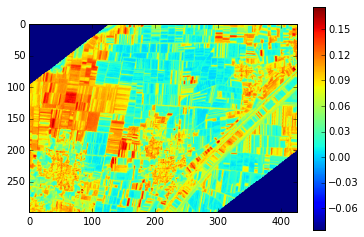

In [321]:
plt.imshow(a[1]-a[1][a[1]!=0].min())
plt.colorbar()

In [322]:
conved = signal.fftconvolve(a[1]-a[1][a[1]!=0].min(), ker, mode='valid')

<matplotlib.colorbar.Colorbar instance at 0x232141128>

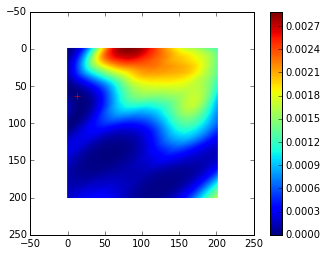

In [323]:
dif = (conved-a[2])**2
plt.imshow(dif)
x,y = np.where(dif==dif.min())
plt.plot(y,x, 'r+')
plt.colorbar()

In [ ]:
xwin, ywin = 100, 100  
cost = []
start = 1

for xstd in np.arange(8,20,1):
    for ystd in np.arange(10,30,1):
        if xstd <=ystd:
            for angle in xrange(30,160, 2):
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                            
                kernel = np.zeros((99, 225))
                kernel[inds[1], inds[0]] = gaus.ravel()

                if kernel.sum() <= 0:
                    print 'invalid gauss: %s'%([xstd, ystd, angle])
                    pass
                else:
                    ker = kernel/(kernel.sum())
                    conved = signal.fftconvolve(to_conv, ker, mode='valid')
                    dif = abs(conved-brdf)
                    minm = np.nanmin(dif)
                    if minm<start:
                        x = np.where(dif == minm)[0][0]-np.ceil((conved.shape[0])/2.)
                        y = np.where(dif == minm)[1][0]-np.ceil((conved.shape[1])/2.)
                        vals = conved[np.where(dif == minm)[0][0], np.where(dif == minm)[1][0]]
                        cost.append([xstd, ystd, angle, x, y , brdf, vals])
                        start = minm
                        print 'Find One!!', start

This pixel way of doing the finding minimum is easily get trapped into local minimums, so a whole image way may be better.